# World Data League 2023

## 🎯 Challenge
*Determining The Main Mobility Flows in the City
of Lisbon Based on Mobile Device Data*


## Team: CEOS
## 👥 Authors
* Ana Maria Sousa
* Duarte Rodrigues
* Mariana Sousa
* Mariana Xavier
* Ricardo Brioso

## 💻 Development

In the last 40 years, 300,000 people have moved from the city of Lisbon to its outlying metropolitan area. Consequently, there is a need to improve the travel experience by public transport in order to decrease the number of people who use their cars for their commuting. Our goal is to understand the movement of people in the city and predict their behavior in the future, in order to  discover how different conditions affect the distribution of people.

We have five datasets: 

*   DISPOSITIVOS_MOVEIS_QUADRICULAS - Coordinates of the centroids of the 200x200 m squares, in the city of Lisbon
*   CONDICIONAMENTOS_TRANSITO - Registration of traffic conditioning/restrictions
*   DISPOSITIVOS_MOVEIS_GRELHA_E_EIXOS - information related to the active mobile phones per square of 200m/200m every 15 minutes , as well as, the ones entering and leaving the city.
*   Waze_QUEBRA_DE_SERIE - Registration of the traffic level and speed or dealy through the WAZE platform
*   (external dataset) LisboaAberta ["Monitorization of Environmental Parameters in the city of Lisbon"](https://dados.cm-lisboa.pt/dataset/monitorizacao-de-parametros-ambientais-da-cidade-de-lisboa) - Precipitation value in Lisbon registered in milimeters (mm)


All this information will be used to analyse, for every 15 minutes: 


*  how many people are located in each Lisbon zone (grid square);
*  if the city is in a rush hour;
*  if the overall city is congested;
*  if the overall city is slow delay;
*  how much is raining  on the entire city.










### Imports and requirements

In [ ]:
# Requirements

!pip install basemap
!pip install geopandas

In [ ]:
# Imports

import os
import re
import cv2
import ast
import json
import time
import joblib
import folium
import warnings
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from bs4 import BeautifulSoup
from datetime import datetime
from xgboost import XGBRegressor
from IPython.display import display
from mpl_toolkits.basemap import Basemap
from google.colab import drive, data_table
from shapely.geometry import Point, Polygon
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import PillowWriter, FuncAnimation
from sklearn import utils, preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [ ]:
# Mount google drive

drive.mount('/content/drive')

### Necessary functions

In [ ]:
def inter_from_256(x):
  ''' Returns the result of interpolation from 256. '''

  return np.interp(x=x,xp=[0,255],fp=[0,1])


def build_custom_color_map():
  ''' Creates custom color map to be used for matplotlib plots. '''

  colors_dict = {
    'red':((0.0, inter_from_256(64), inter_from_256(64)),
           (1/5*1, inter_from_256(112), inter_from_256(112)),
           (1/5*2, inter_from_256(230), inter_from_256(230)),
           (1/5*3, inter_from_256(253), inter_from_256(253)),
           (1/5*4 ,inter_from_256(244), inter_from_256(244)),
           (1.0, inter_from_256(169), inter_from_256(169))),
    'green': ((0.0, inter_from_256(57), inter_from_256(57)),
            (1/5*1, inter_from_256(198), inter_from_256(198)),
            (1/5*2, inter_from_256(241), inter_from_256(241)),
            (1/5*3, inter_from_256(219), inter_from_256(219)),
            (1/5*4, inter_from_256(109), inter_from_256(109)),
            (1.0, inter_from_256(23), inter_from_256(23))),
    'blue': ((0.0, inter_from_256(144), inter_from_256(144)),
              (1/5*1, inter_from_256(162), inter_from_256(162)),
              (1/5*2, inter_from_256(246), inter_from_256(146)),
              (1/5*3, inter_from_256(127), inter_from_256(127)),
              (1/5*4, inter_from_256(69), inter_from_256(69)),
              (1.0, inter_from_256(69), inter_from_256(69))),
  }

  return LinearSegmentedColormap('custom_cmap', segmentdata=colors_dict)

### EDA - data quality and analysis

In [ ]:
root_dir = '/content/drive/My Drive/WDL/1stPhase/DATA'

One of the first datasets to explore was the one which defines the grids that belong in the city of Lisbon to understand its potential.
It comprises of the 24 different "freguesias" in Lisbon along with its location (latitude/longitude).
This dataset is a good starting plot to visualize how different parameters behave in the different areas of the city.

Data fields: ['grelha_id' 'freguesia' 'latitude' 'longitude']
Number of records: 3743 

24 freguesias: ['Ajuda', 'Alcântara', 'Alvalade', 'Areeiro', 'Arroios', 'Avenidas Novas', 'Beato', 'Belém', 'Benfica', 'Campo de Ourique', 'Campolide', 'Carnide', 'Estrela', 'Lumiar', 'Marvila', 'Misericórdia', 'Olivais', 'Parque das Nações', 'Penha de França', 'Santa Clara', 'Santa Maria Maior', 'Santo António', 'São Domingos de Benfica', 'São Vicente'] 

Latitude [min, max]: [38.692094099, 38.7971892751] 

Longitude [min, max]: [-9.2304171489, -9.09027996458] 



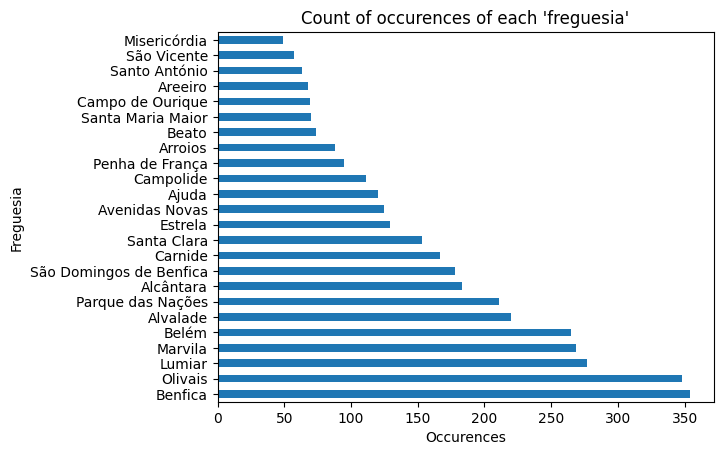

In [ ]:
# Load the data

data_path = os.path.join(root_dir, 'DISPOSITIVOS_MOVEIS_QUADRICULAS',
                    'DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx')

summarized_data = pd.read_excel(data_path, 'resumo')

# Explore the different data fields
print(f'Data fields: {summarized_data.columns.values}')
print(f'Number of records: {len(summarized_data.index)} \n')

freguesias_data = summarized_data.freguesia
unique_freguesias = freguesias_data.unique()
print(f'{len(unique_freguesias)} freguesias: {sorted(unique_freguesias)} \n')

latitude_data = summarized_data.latitude
min_max_latitude = [latitude_data.min(), latitude_data.max()]
print(f'Latitude [min, max]: {min_max_latitude} \n')

longitude_data = summarized_data.longitude
min_max_longitude = [longitude_data.min(), longitude_data.max()]
print(f'Longitude [min, max]: {min_max_longitude} \n')

summarized_data.freguesia.value_counts().plot(kind='barh',
                                              title = f'Count of occurences of each \'freguesia\'',
                                              xlabel='Occurences',
                                              ylabel='Freguesia');

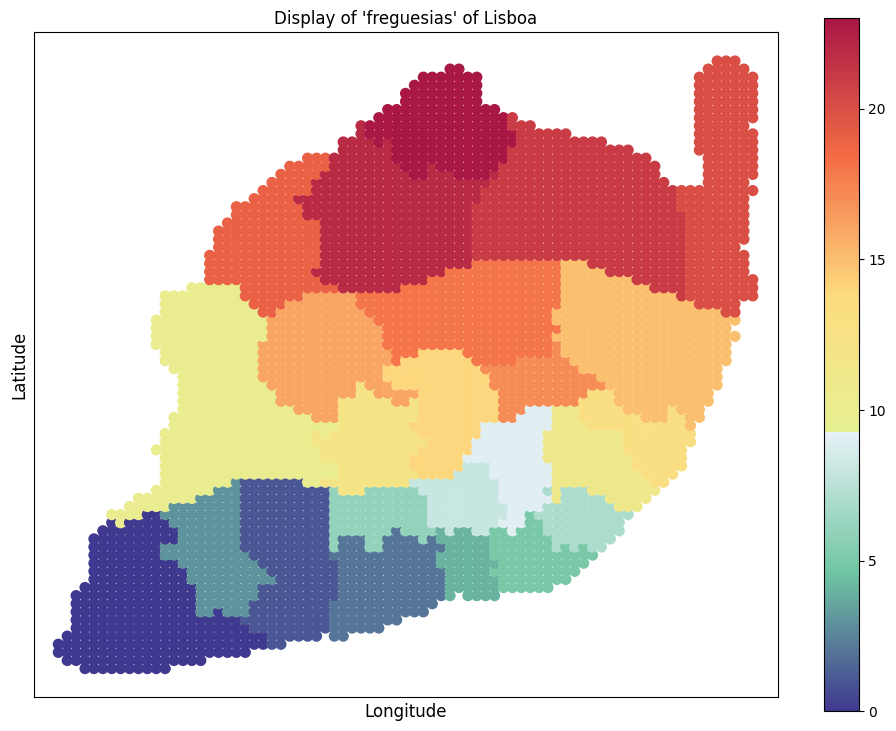

In [ ]:
# Display of 'freguesias' of Lisboa using Basemap library

# Set the size of the map
fig = plt.figure(figsize=(12,9))

# Create the map
padding = 0.005
map = Basemap(projection='mill',
              llcrnrlat=min_max_latitude[0]-padding,
              urcrnrlat=min_max_latitude[1]+padding,
              llcrnrlon=min_max_longitude[0]-padding,
              urcrnrlon=min_max_longitude[1]+padding,
              resolution='c')

# Get additional variables needed for the display
encoded_labels = [np.where(np.array(list(dict.fromkeys(freguesias_data)))==e)[0][0] for e in freguesias_data]
color_map = build_custom_color_map()

# Plot the created map
map.scatter(longitude_data.tolist(), latitude_data.tolist(), latlon=True,
            s=50, c=encoded_labels, marker='o', alpha=1, cmap=color_map)
plt.title('Display of \'freguesias\' of Lisboa')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.colorbar()
plt.show()

Then, the traffic conditioning dataset was explored.
It was observed that there are 3075 impacts of type 'relevante' for 449 impacts of type 'pouco relevante', which is certainly an information that affects the way people move throughout the city.
Besides, having the impact of each restriction also seems like a very important information to retain.
A possible correlation between the inpact with types of restriction was performed but a very relevant correlation was not found: parking space is more correlated with 'pouco relevante' (0.28) and lane narrowing with 'revelante' (0.22).

Data fields: ['creation_date' 'entity_id' 'position' 'impacto' 'morada' 'motivo'
 'periodos_condicionamentos' 'restricao_circulacao']
Number of records: 3524 

Types of impact: ['Pouco relevante', 'Relevante'] 



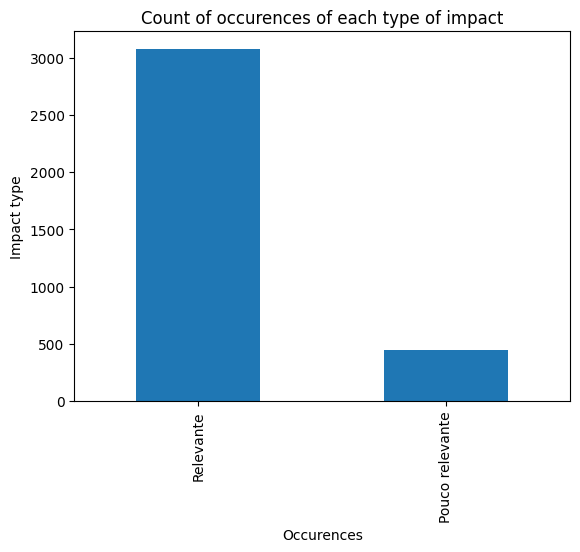

In [ ]:
# Load the data

data_path = os.path.join(root_dir, 'CONDICIONAMENTOS_TRANSITO',
                    'CONDICIONAMENTOS TRANSITO_Set_Out_Nov2022.csv')
data = pd.read_csv(data_path)

# Explore the different data fields

print(f'Data fields: {data.columns.values}')
print(f'Number of records: {len(data.index)} \n')

impacto_data = data.impacto
unique_impacto = impacto_data.unique()
print(f'Types of impact: {sorted(unique_impacto)} \n')
data.impacto.value_counts().plot(kind='bar',
                                 title='Count of occurences of each type of impact',
                                 xlabel='Occurences',
                                 ylabel='Impact type');

Motives for traffic conditioning: ['ACESSO DE VEÍCULOS À OBRA', 'ARRAIAL', 'AUTOGRUA', 'BETONAGENS', 'BETONAGENS/CARGAS DESCARGAS', 'CAMINHADA', 'CARGAS E DESCARGAS', 'CARGAS E DESCARGAS/OBRAS', 'CONCENTRAÇÃO', 'CORRIDA', 'DESFILE', 'DESMONTAGEM DE GRUA', 'EVENTO', 'FILMAGENS', 'ILUMINAÇÃO PÚBLICA', 'INSPECÇÃO COLECTORES - FAIXA DE RODAGEM', 'LIGAÇÃO DE RAMAL - FAIXA DE RODAGEM', 'LIGAÇÃO DE RAMAL - PASSEIO E ESTACION.', 'MANIFESTAÇÃO', 'MONTAGEM DE GRUA', 'MUDANÇAS', 'OBRA - FAIXA DE RODAGEM', 'OBRA - PASSEIO E ESTACION.', 'OBRAS NO SUBSOLO - FAIXA DE RODAGEM', 'OBRAS NO SUBSOLO - PASSEIO E ESTACION.', 'PINTURAS', 'PLANTAÇÃO / PODA DE ÁRVORES', 'PROCISSÃO', 'REP. COLECTOR/RAMAL - PASSEIO E ESTAC.', 'REP. DE COLECTOR/RAMAL- FAIXA DE RODAGEM', 'REPAVIMENTAÇÕES', 'RESERVA DE ESTACIONAMENTO', 'SONDAGENS - FAIXA DE RODAGEM', 'SONDAGENS - PASSEIO E ESTACION.', 'SUBSTITUIÇÃO DE CAIXA MULTIBANCO', 'VIGILIA'] 



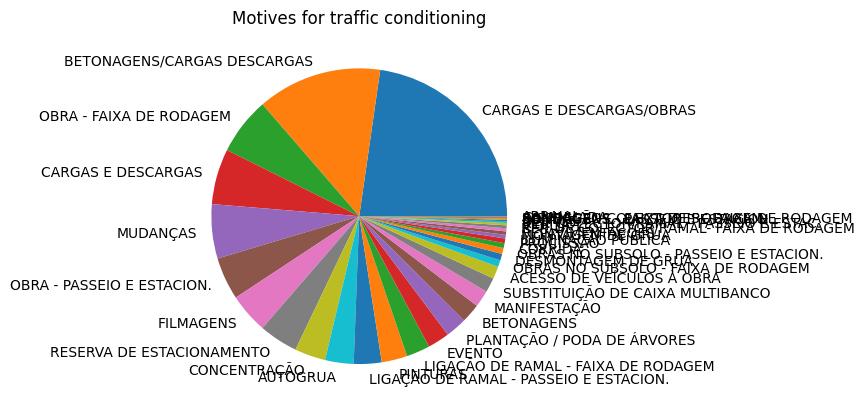

In [ ]:
# Explore the motives for conditioning

motivo_data = data.motivo
unique_motivo = motivo_data.unique()
print(f'Motives for traffic conditioning: {sorted(unique_motivo)} \n')
plt.close()
data.motivo.value_counts().plot(kind='pie',
                                title='Motives for traffic conditioning',
                                ylabel='');

Types of traffic restriction: ['Corte num sentido', 'Corte total', 'Cortes temporários', 'Estacionamento', 'Estreitamento de via', 'Mantém perfil de via', 'Passeio'] 



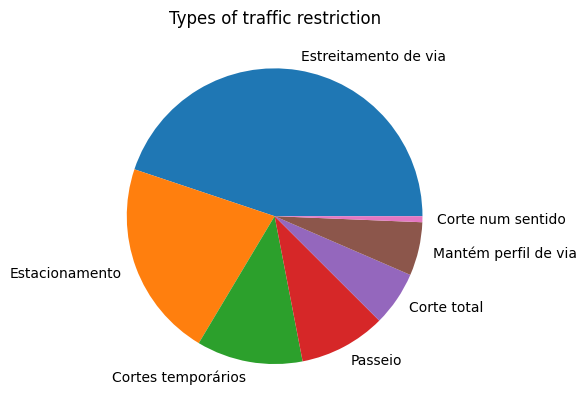

In [ ]:
# Explore the types of restriction

restricao_circulacao_data = data.restricao_circulacao
unique_restricao_circulacao = restricao_circulacao_data.unique()
print(f'Types of traffic restriction: {sorted(unique_restricao_circulacao)} \n')
plt.close()
data.restricao_circulacao.value_counts().plot(kind='pie',
                                              title='Types of traffic restriction',
                                              ylabel='');

In [ ]:
# Study a possible correlation between the restrictions and its impact

correlation_data = data[['impacto', 'restricao_circulacao']].copy()
correlation_data = pd.get_dummies(correlation_data)
correlation_data.corr()

,impacto_Pouco relevante,impacto_Relevante,restricao_circulacao_Corte num sentido,restricao_circulacao_Corte total,restricao_circulacao_Cortes temporários,restricao_circulacao_Estacionamento,restricao_circulacao_Estreitamento de via,restricao_circulacao_Mantém perfil de via,restricao_circulacao_Passeio
impacto_Pouco relevante,1.000000,-1.000000,-0.030972,-0.060564,-0.077351,0.283833,-0.204377,0.002732,0.088456
impacto_Relevante,-1.000000,1.000000,0.030972,0.060564,0.077351,-0.283833,0.204377,-0.002732,-0.088456
restricao_circulacao_Corte num sentido,-0.030972,0.030972,1.000000,-0.020455,-0.029370,-0.042502,-0.073113,-0.020196,-0.026227
restricao_circulacao_Corte total,-0.060564,0.060564,-0.020455,1.000000,-0.091446,-0.132333,-0.227646,-0.062882,-0.081660
restricao_circulacao_Cortes temporários,-0.077351,0.077351,-0.029370,-0.091446,1.000000,-0.190007,-0.326860,-0.090288,-0.117249
restricao_circulacao_Estacionamento,0.283833,-0.283833,-0.042502,-0.132333,-0.190007,1.000000,-0.473007,-0.130657,-0.169674
restricao_circulacao_Estreitamento de via,-0.204377,0.204377,-0.073113,-0.227646,-0.326860,-0.473007,1.000000,-0.224763,-0.291882
restricao_circulacao_Mantém perfil de via,0.002732,-0.002732,-0.020196,-0.062882,-0.090288,-0.130657,-0.224763,1.000000,-0.080626
restricao_circulacao_Passeio,0.088456,-0.088456,-0.026227,-0.081660,-0.117249,-0.169674,-0.291882,-0.080626,1.000000


Secondly, we analysed the dataset that contained points and lines of important street segments. We were only able to display the points of interest in the map of lisbon on top of the map that divides the "freguesias" in grids.
In this submission we did not use the information from these points.

In [ ]:
# Load the data
trocosViaPointsShapeFilePath = os.path.join(root_dir,
                                            'DISPOSITIVOS_MOVEIS_TROÇOS_DE_VIA/DISPOSITIVOS MOVEIS_TROÇOS VIA_PONTOS/Entradas_Lx.shp')
trocosViaPolygonsShapeFilePath = os.path.join(root_dir,
                                              'DISPOSITIVOS_MOVEIS_TROÇOS_DE_VIA'
                                              'DISPOSITIVOS MOVEIS_TROÇOSVIA_POLIGONOS',
                                              'eixos_polygon.shp')
trocosViaPoints = gpd.read_file(trocosViaPointsShapeFilePath)
trocosViaPolygons = gpd.read_file(trocosViaPolygonsShapeFilePath)

# Turning the crs of the points into the one of the polygons
trocosViaPoints.to_crs(trocosViaPolygons.crs, inplace=True)


quadriculas_path = os.path.join(root_dir, 'DISPOSITIVOS_MOVEIS_QUADRICULAS',
                    'DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx')

summarized_data = pd.read_excel(quadriculas_path, 'resumo')
print(trocosViaPolygons['geometry'])

latitude_data = summarized_data.latitude
min_max_latitude = [latitude_data.min(), latitude_data.max()]
longitude_data = summarized_data.longitude
min_max_longitude = [longitude_data.min(), longitude_data.max()]

trocosViaPoints.to_crs(epsg=4326, inplace=True)
trocosViaPolygons.to_crs(epsg=4326,inplace=True)

# Group the data by "freguesias" and get the mean lat/lon values for each group
grouped_data = summarized_data.groupby('freguesia').mean()

# Create a list of unique "freguesias" values
freguesias = grouped_data.index.tolist()

# Create a color map with a unique color for each "freguesia"
color_map = cm.get_cmap('tab20')
num_colors = len(freguesias)
colors_list = [colors.rgb2hex(color_map(i/num_colors)) for i in range(num_colors)]

# Create a dictionary mapping each "freguesia" to a color
color_dict = dict(zip(freguesias, colors_list))

# Add a new column to the original data with the color for each "freguesia"
summarized_data['color'] = summarized_data['freguesia'].map(color_dict)

fig = go.Figure()

# Create the plotly figure with the initial data
fig = go.Figure(go.Scattermapbox(
    lat=summarized_data['latitude'],
    lon=summarized_data['longitude'],
    mode='markers',
    marker=dict(
        size=10,
        color=summarized_data['color'],
        opacity=0.3
    )
))

# Add the map layout
fig.update_layout(
    mapbox=dict(
        style='open-street-map',
        zoom=10,
        center=dict(
            lat=summarized_data['latitude'].mean(),
            lon=summarized_data['longitude'].mean()
        )
    )
)

# Add the points to the figure
fig.add_trace(go.Scattermapbox(
    name="Points",
    mode="markers",
    lon=trocosViaPoints.geometry.x,
    lat=trocosViaPoints.geometry.y,
    text=trocosViaPoints['Local'],
    hoverinfo='text',
    marker=dict(
        size=10,
        color='red',
        opacity=0.7
    )
))

# Show the map
fig.show()

0     POLYGON ((-9.17344 38.67683, -9.17352 38.67683...
1     POLYGON ((-9.28350 38.69782, -9.28249 38.69857...
2     POLYGON ((-9.26706 38.71583, -9.26535 38.71479...
3     POLYGON ((-9.23394 38.74670, -9.23394 38.74670...
4     POLYGON ((-9.26365 38.74928, -9.26273 38.74885...
5     POLYGON ((-9.23606 38.78764, -9.23583 38.78692...
6     POLYGON ((-9.18276 38.81267, -9.18280 38.81123...
7     POLYGON ((-9.13946 38.80312, -9.13867 38.80297...
8     POLYGON ((-9.10477 38.80721, -9.10454 38.80721...
9     POLYGON ((-8.99149 38.72862, -8.99168 38.72848...
10    POLYGON ((-9.09178 38.80488, -9.09155 38.80484...
Name: geometry, dtype: geometry


<ipython-input-13-f102b6abc13e>:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20')


Then, the bar plot of how many occurrences (number of people) were present in each grid ID was observed per hour.

In [ ]:
pathcsv = os.path.join(root_dir,
                       'DISPOSITIVOS_MOVEIS_GRELHA_E_EIXOS',
                       'CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_09_0001_4000.csv')

data = pd.read_csv(pathcsv, usecols = ['Grid_ID', 'Datetime','C1'])

In [ ]:
griNumMaxList = []
for gridNum in range(max(data['Grid_ID'])):
  data_oneGrid=data[data['Grid_ID'] == gridNum+1]
  griNumMaxList.append(max(data_oneGrid['C1']))

avgGridMax = np.percentile(griNumMaxList,95) # using the mean decreases a lot since we are comparing the whole city as the same. but it is very uneven!

gridCongested = data[data['C1'] >= avgGridMax]
gridCongested['Datetime'] = pd.to_datetime(gridCongested['Datetime'])
gridCongested = gridCongested.reset_index(drop=True)

In [ ]:
# Group the data by hour slots of the day and count the number of unique days for each ID - ajudinha do chatGPT
hourly_counts = gridCongested.groupby([gridCongested['Grid_ID'], pd.Grouper(key='Datetime', freq='H')]).agg({'Datetime': pd.Series.nunique}).unstack(fill_value=0)
hourly_counts = hourly_counts.droplevel(level=0, axis=1)
hourly_counts = hourly_counts.T.rename_axis(None) 

# Group by hour and sum for each ID
grouped = hourly_counts.groupby(hourly_counts.index.strftime('%H')).sum()
grouped.index = grouped.index + ':00'

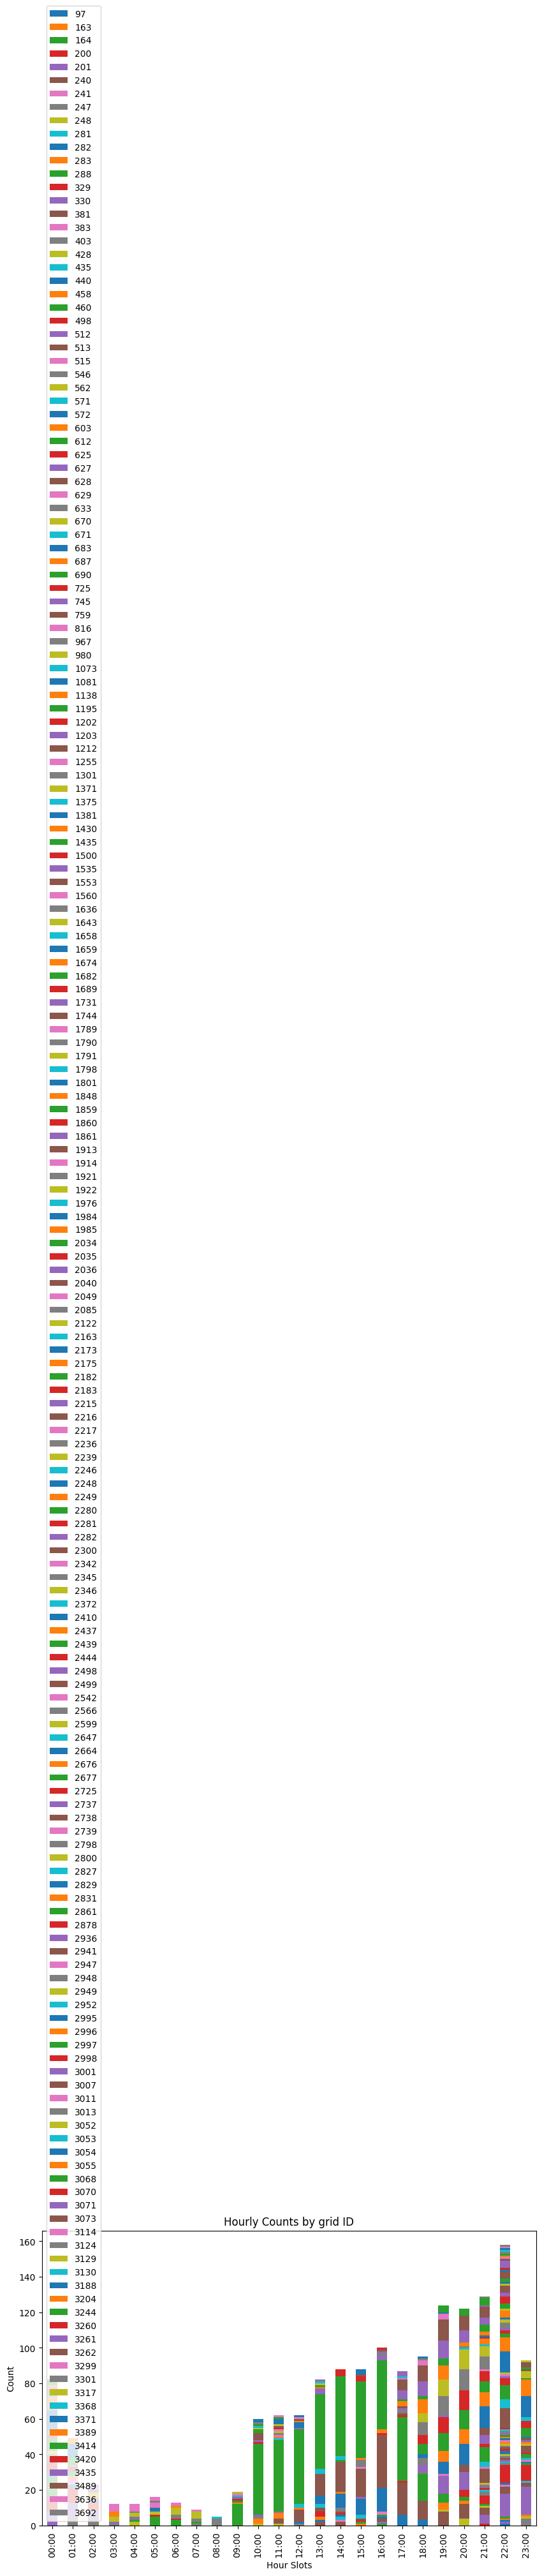

In [ ]:
# Create the stacked bar plot
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set the legend
ax.legend()

# Set the title and labels
ax.set_title('Hourly Counts by grid ID')
ax.set_xlabel('Hour Slots')
ax.set_ylabel('Count')

# Show the plot
plt.show()

Finally, it is possible to see the location of the rain sensors that were responsible for collecting the rain depth (mm) values in the city of Lisbon.

In [ ]:
URL = 'http://opendata-cml.qart.pt/locations'
page = requests.get(URL)
data_list = json.loads(page.text)

path = '/content/drive/My Drive/DATA/Meteorologia/sensor_location_id.json'

with open(path, 'w') as f:
  json.dump(data_list, f)

sensor_loc_path = '/content/drive/My Drive/DATA/Meteorologia/sensor_location_id.json'

with open(sensor_loc_path, 'r') as f:
  sensor_loc_data = json.load(f)

URL = 'http://opendata-cml.qart.pt/locations'
page = requests.get(URL)
sensor_loc_data = json.loads(page.text)
rain_dict = {}
for locID in sensor_loc_data:
  for sensor in locID['sensors']:
    if 'ME00PP' in sensor['id']:
      rain_dict[sensor['id']] = [locID['coordinates']['lat'],locID['coordinates']['lng']]

lat_list=[]
lng_list=[]
for val in rain_dict.values():
  lat_list.append(val[0])
  lng_list.append(val[1])

In [ ]:
data_path = os.path.join(root_dir, 'DISPOSITIVOS_MOVEIS_QUADRICULAS', 'DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx')

summarized_data = pd.read_excel(data_path, 'resumo')

freguesias_data = summarized_data.freguesia
unique_freguesias = freguesias_data.unique()

latitude_data = summarized_data.latitude
min_max_latitude = [latitude_data.min(), latitude_data.max()]
longitude_data = summarized_data.longitude
min_max_longitude = [longitude_data.min(), longitude_data.max()]

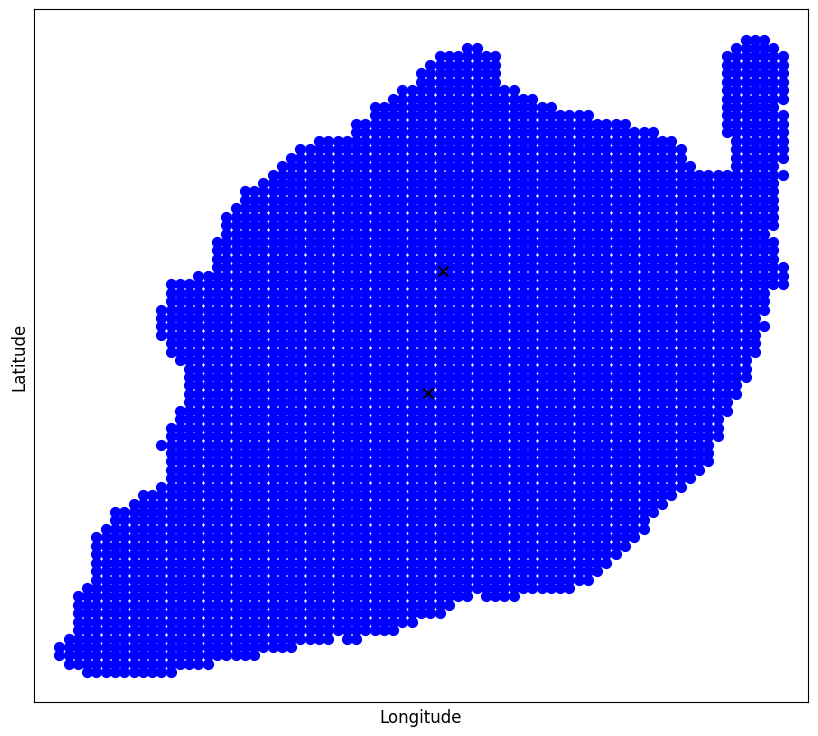

In [ ]:
# Create the map
padding = 0.005
fig, ax = plt.subplots(figsize=(12, 9))
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
map = Basemap(projection='mill',
              llcrnrlat=min_max_latitude[0]-padding,
              urcrnrlat=min_max_latitude[1]+padding,
              llcrnrlon=min_max_longitude[0]-padding,
              urcrnrlon=min_max_longitude[1]+padding,
              resolution='c')
scat = map.scatter(longitude_data.tolist(), latitude_data.tolist(), latlon=True, s=50, marker='o', alpha=1,color = 'blue')
scat = map.scatter(lng_list, lat_list, latlon=True, s=50, marker='x', alpha=1,color = 'black')
plt.show()

The sensors for rain are close together, so we assumed that the rain for all the locations in Lisbon is the average of the values registered on both places.

In the end, we also wanted to create an animation with the movement of the data throughout the city of Lisbon, so the following code was used for these animations - the link for these videos is present in the visualization section below.

In [ ]:
pathcsv = os.path.join(root_dir,
                       'DISPOSITIVOS_MOVEIS_GRELHA_E_EIXOS',
                       'CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_09_0001_4000.csv')
ori_df = pd.read_csv(pathcsv,usecols = ['Grid_ID','Datetime','C1'])
dt_range = pd.date_range(start='2022-09-01 00:00:00+00:00', end='2022-09-30 23:45:00+00:00', freq='15min')
id_range = range(1, 3744) # Number of grid cells
df_all = pd.DataFrame({'Grid_ID': list(id_range)*len(dt_range), 'Datetime': list(dt_range)*len(id_range)})

In [ ]:
ori_df['Datetime'] = pd.to_datetime(ori_df['Datetime'])

# Merge with the original dataframe
data = pd.merge(df_all, ori_df, on=['Grid_ID', 'Datetime'], how='left')

# Fill missing values in C1 column with 0.00
data['C1'].fillna(0.00, inplace=True)


In [ ]:
C1_max = data.C1.max()
C1_min = data.C1.min()

data_time_sorted = data.sort_values('Datetime', ascending=True)
data_time_sorted = data_time_sorted.reset_index(drop=True)
display(data_time_sorted[:3743]) #first 15 min interval in all the grid squares

In [ ]:
# Verification if the cropped df has all the grid_ID's for the same time - 
# compares the first and last entry of the cropped df to check if they are the same
not_same_time = [] 
not_same_grid = []

for a in range(0,len(data_time_sorted)-7486,3743):
  crop_df = data_time_sorted[a:a+3743].sort_values('Grid_ID', ascending=True)
  data_crop_sorted = crop_df.reset_index(drop=True)
  if data_crop_sorted['Datetime'][0] != data_crop_sorted['Datetime'][3742]:
    if len(not_same_time) == 0:
      display(data_crop_sorted)
    not_same_time.append((data_crop_sorted['Datetime'][0],data_crop_sorted['Datetime'][3742]))
    not_same_grid.append((data_crop_sorted['Grid_ID'][0],data_crop_sorted['Grid_ID'][3742]))

print(not_same_time)
print(not_same_grid)

In [ ]:
# Display of 'freguesias' of Lisboa using Basemap library into an animation

a=0
numDaysMonth = 30
for day in range(numDaysMonth):
  print('Starting Day '+ str(day+1))
  # Create the map
  padding = 0.005

  # Define the figure and axis
  fig, ax = plt.subplots(figsize=(12, 9))
  plt.xlabel('Longitude', fontsize=12)
  plt.ylabel('Latitude', fontsize=12)
  map = Basemap(projection='mill',
                llcrnrlat=min_max_latitude[0]-padding,
                urcrnrlat=min_max_latitude[1]+padding,
                llcrnrlon=min_max_longitude[0]-padding,
                urcrnrlon=min_max_longitude[1]+padding,
                resolution='c')

  # Define the scatter plot object
  scat = map.scatter([], [], c=[],latlon=True,
                  s=50, marker='o', alpha=1, cmap='viridis', vmin=C1_min, vmax=C1_max)

  # Define the function to update the scatter plot for each frame of the animation
  def update(frame):

      # Get the population per square
      global a
      crop_df = data_time_sorted[a:a+3743].sort_values('Grid_ID', ascending=True)
      data_crop_sorted = crop_df.reset_index(drop=True)
      enc_lab = data_crop_sorted['C1']

      # Set the title of the plot with the current frame number
      ax.set_title('Time: ' + data_crop_sorted['Datetime'][0].strftime("%d/%m/%Y %H:%M:%S"))
      print(data_crop_sorted['Datetime'][0])
      # Update the scatter plot with the new data
      scat = map.scatter(longitude_data.tolist(), latitude_data.tolist(), latlon=True,
                  s=50, c=enc_lab, marker='o', alpha=1, cmap='viridis')#, vmin=C1_min, vmax=C1_max )

      if a % (96*3743) == 0:
        print('passed here')
        maxDayC1 = np.percentile(data_time_sorted['C1'][a:a+3743*95].tolist(),80)
        minDayC1 = data_time_sorted['C1'][a:a+3743*95].min()
        
        # Define the colorbar
        cbar = plt.colorbar(scat)
        # Update the colorbar limits based on the min and max values of C
        plt.clim(minDayC1,maxDayC1)

      a += 3743
  
      return scat

  # Create the animation
  ani = FuncAnimation(fig, update, frames=95, interval=250, blit=False) # animação para 1 dia

  # save the animation to a path as an mp4 file
  ani.save('/content/drive/My Drive/WDL/1stPhase/Visualization/NormDay/Day'+str(day+1)+'animationNormalized.mp4', writer='ffmpeg')
  # Show the animation
  # plt.show()

### Data engineering

In [ ]:
root_dir = '/content/drive/My Drive/WDL/1stPhase/DATA'

In order to be able to analyze the data it was necessary to perform the handling of the data from the different dataframes to enable their merging in a single dataframe table with the features of interest and their subsequent use in predictive models.

Being the meteorological dataset external, it needed to be arranjed first to be able to merge it with the remaining data, which is shown below.

In [ ]:
# Online data scrapping to get the sensor locations from the available website
URL = 'http://opendata-cml.qart.pt/locations'
page = requests.get(URL)
sensor_loc_data = json.loads(page.text)

# For each rain sensor in Lisbon, it gets the correspondent geographic coordinates
rain_dict = {}
for locID in sensor_loc_data:
  for sensor in locID['sensors']:
    if 'ME00PP' in sensor['id']:
      rain_dict[sensor['id']] = [locID['coordinates']['lat'],locID['coordinates']['lng']]

# Online data scrapping process for the data of the specific sensors selected previously - rain
sensor_FullData_list = []
for sensor_name in rain_dict.keys():
  URL = 'http://opendata-cml.qart.pt/measurements/'+sensor_name+'?startDate=202209010000&endDate=202209302345' # September only
  page = requests.get(URL)
  sensor_data_list = json.loads(page.text)
  data_dict = {}
  for entry in sensor_data_list:
    data_dict[datetime.strptime(entry['date'], '%Y%m%d%H%M')] = entry["value"]
    
  sensor_FullData_list.append(data_dict)

# In this case there are 2 rain sensors - guarantee they have same number of entries - 1 entry per hour for all days
if len(sensor_FullData_list[0]) != len(sensor_FullData_list[1]):
    if len(sensor_FullData_list[0]) < len(sensor_FullData_list[1]):
        for key in sensor_FullData_list[1]:
            if key not in sensor_FullData_list[0]:
                sensor_FullData_list[0][key] = sensor_FullData_list[1][key]
    else:
        for key in sensor_FullData_list[0]:
            if key not in sensor_FullData_list[1]:
                sensor_FullData_list[1][key] = sensor_FullData_list[0][key]


# Extract keys
keys = sensor_FullData_list[0].keys()

# Initialize empty list to store values
values = [[] for _ in range(len(keys))]

# Loop through dictionaries and append values
for dict_ in sensor_FullData_list:
    for i, k in enumerate(keys):
        values[i].append(dict_[k])

# Create dataframe, droping sensor 1 since it had all values at 0 all the days
rain_df = pd.DataFrame({k: v for k, v in zip(keys, values)}, index=['Sensor1','Sensor2']).T.drop(columns='Sensor1')

# To match the values of the WDL data, the rain values need to be resampled from hourly values to the 4 intervals of 15 minutes
rain_df_15min = rain_df.resample('15T').ffill()
rain_df_15min.reset_index(inplace=True)
rain_df_15min.rename(columns={'index': 'Datetime', 'Sensor2':'SensorRain'}, inplace=True)
rain_df_15min.index = range(len(rain_df_15min ))

# To match the grid of the WDL, it is needed to assume the rain value is the same in all Lisbon, so all the grid has the same value, on the same 15min interval
rain_df_15min_grid = pd.DataFrame({'Datetime': rain_df_15min['Datetime'].repeat(3743), 'SensorRain': rain_df_15min['SensorRain'].repeat(3743)})
rain_df_15min_grid['Grid_ID'] = rain_df_15min_grid.groupby('Datetime').cumcount() + 1
rain_df_15min_grid['Datetime'] = pd.to_datetime(rain_df_15min_grid['Datetime'],utc=True)
rain_df_15min_grid.reset_index(inplace=True)

In [ ]:
display(rain_df_15min_grid)

,index,Datetime,SensorRain,Grid_ID
0,0,2022-09-01 00:00:00+00:00,0.0,1
1,0,2022-09-01 00:00:00+00:00,0.0,2
2,0,2022-09-01 00:00:00+00:00,0.0,3
3,0,2022-09-01 00:00:00+00:00,0.0,4
4,0,2022-09-01 00:00:00+00:00,0.0,5
...,...,...,...,...
10768606,2876,2022-09-30 23:00:00+00:00,0.0,3739
10768607,2876,2022-09-30 23:00:00+00:00,0.0,3740
10768608,2876,2022-09-30 23:00:00+00:00,0.0,3741
10768609,2876,2022-09-30 23:00:00+00:00,0.0,3742


Moving on to the remainind datasets, in this first analysis, we define as relevant features for the analysis of a predictive model: grid id, datetime, number of people the grid registered for each datetime and the previous rain information. And so these are the features contained in the dataframe that we will use as a starting point for the application of machine learning models. 

In [ ]:
def get_grid_ids_by_freguesia(df_grid, freguesia):
    # Filter the dataframe by freguesia
    df_grid_filtered = df_grid[df_grid['freguesia'] == freguesia]
    
    # Get a list of the Grid_IDs in the filtered dataframe
    grid_ids = list(df_grid_filtered['Grid_ID'])
    
    return df_grid_filtered, grid_ids

In [ ]:
peopleSquares_path = os.path.join(root_dir,
                                  'DISPOSITIVOS_MOVEIS_GRELHA_E_EIXOS',
                                  'CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_09_0001_4000.csv')
grid_path = os.path.join(root_dir,
                         'DISPOSITIVOS_MOVEIS_QUADRICULAS',
                         'DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx')

# Read in data from Excel and CSV files
df_peopleSquares = pd.read_csv(peopleSquares_path, usecols=['Grid_ID', 'Datetime', 'C1'])
df_peopleSquares['Datetime'] = pd.to_datetime(df_peopleSquares['Datetime'], utc=True)
df_peopleSquares = df_peopleSquares.rename(columns={'C1': 'NumPeople'})

# Read in data from Excel and CSV files
df_grid = pd.read_excel(grid_path, sheet_name='resumo', usecols=['grelha_id', 'latitude', 'longitude', 'freguesia'])
df_grid.rename(columns={"grelha_id": "Grid_ID"}, inplace=True)

# Filter the Grid_Ids by "freguesia". We only analysed 'Campolide'.
df_grid_filtered, grid_ids = get_grid_ids_by_freguesia(df_grid, 'Campolide')

# Creating the dataframe that for each grid square has all the 15 minute intervals between the dates below - (around 320.000 rows)
dt_range = pd.date_range(start='2022-09-01 00:00:00+00:00', end='2022-09-30 23:45:00+00:00', freq='15min')
df = pd.DataFrame({'Grid_ID': list(grid_ids)*len(dt_range), 'Datetime': list(dt_range)*len(grid_ids)})

# If any value is missing it appears as NaN
df = pd.merge(df, df_peopleSquares, on=['Grid_ID', 'Datetime'], how='left')

# Merge with the rain dataset
df = pd.merge(df, rain_df_15min_grid, on=['Grid_ID', 'Datetime'], how='left')
df['SensorRain'].fillna(0.00, inplace=True)
df.drop(columns='index',inplace=True)

# Drop missing values (NaN) if exist 
df = df.dropna(subset=['NumPeople'])

# Divide the datetime field in a three separated fields: 'hour' 'minute' and 'day_of_the_week'
df['hour'] = df['Datetime'].dt.hour
df['minute'] = df['Datetime'].dt.minute
df['day_of_the_week'] = df['Datetime'].dt.dayofweek

display(df)

,Grid_ID,Datetime,NumPeople,SensorRain,hour,minute,day_of_the_week
0,1011,2022-09-01 00:00:00+00:00,56.860001,0.0,0,0,3
1,1012,2022-09-01 00:15:00+00:00,110.230003,0.0,0,15,3
2,1013,2022-09-01 00:30:00+00:00,571.159973,0.0,0,30,3
3,1065,2022-09-01 00:45:00+00:00,44.860001,0.0,0,45,3
4,1066,2022-09-01 01:00:00+00:00,45.389999,0.0,1,0,3
...,...,...,...,...,...,...,...
319675,1661,2022-09-30 22:45:00+00:00,280.059998,0.0,22,45,4
319676,1664,2022-09-30 23:00:00+00:00,212.380005,0.0,23,0,4
319677,1718,2022-09-30 23:15:00+00:00,41.730000,0.0,23,15,4
319678,1719,2022-09-30 23:30:00+00:00,352.329987,0.0,23,30,4


Next, the idea would be to join the traffic conditioning per grid id and datetime. This was divided in two steps:


1.   First, a preprocessing of this dataframe to figure out which grid cells were affected by each conditioning.
2.   Second, for each row in the original table, if a conditioning was present for each datetime and grid id pair, information on its impact is added.

Due to time constraincts, only the first step was performed, which is shown below. The second step, although it works, was never performed until the end, reason why it is present in the annexes.



In [ ]:
# Load necessary datasets
grid_path = os.path.join(root_dir,
                         'DISPOSITIVOS_MOVEIS_QUADRICULAS',
                         'DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx')
transitConditioning_path = os.path.join(root_dir,
                                        'CONDICIONAMENTOS_TRANSITO',
                                        'CONDICIONAMENTOS TRANSITO_Set_Out_Nov2022.csv')

df_grid = pd.read_excel(grid_path, 'resumo', usecols=['grelha_id', 'latitude', 'longitude']) 
df_grid = df_grid.rename(columns={"grelha_id": "Grid_ID"})

df_transitConditioning = pd.read_csv(transitConditioning_path,
                                     usecols=['position', 'impacto', 'periodos_condicionamentos', 'restricao_circulacao'])
df_transitConditioning['periodos_condicionamentos'] = df_transitConditioning['periodos_condicionamentos'].apply(ast.literal_eval)
df_transitConditioning['position'] = df_transitConditioning['position'].apply(ast.literal_eval)

df_transitConditioning['StartDatetime'] = np.zeros((len(df_transitConditioning)))
df_transitConditioning['EndDatetime'] = np.zeros((len(df_transitConditioning)))

# For each grid id, create a column in the traffic conditioning dataset
for j, grid in df_grid.iterrows():
  grid_id = str(int(grid['Grid_ID']))
  df_transitConditioning[grid_id] = np.zeros((len(df_transitConditioning)), dtype=int)

# For each conditioning, add start and end of it and add information on which grid cells are affected
for i, conditioning in df_transitConditioning.iterrows():

  conditioning_periods = conditioning['periodos_condicionamentos'][0]
  start_datetime = pd.to_datetime(conditioning_periods['date_min'] + ' ' + conditioning_periods['hour_max'] + '+00:00',
                                  format='%Y-%m-%d %H:%M:%S')
  df_transitConditioning['StartDatetime'][i] = start_datetime
  end_datetime = pd.to_datetime(conditioning_periods['date_max'] + ' ' + conditioning_periods['hour_min'] + '+00:00',
                                format='%Y-%m-%d %H:%M:%S')
  df_transitConditioning['EndDatetime'][i] = end_datetime

  conditioning_coordinates = conditioning['position']['geometries'][0]['coordinates']
  min_longitude = conditioning_coordinates[0][0][0]
  max_longitude = conditioning_coordinates[0][1][0]
  min_latitude = conditioning_coordinates[0][0][1]
  max_latitude = conditioning_coordinates[0][1][1]

  for j, grid in df_grid.iterrows():

    longitude = grid['longitude']
    latitude = grid['latitude']

    if longitude >= min_longitude and longitude <= max_longitude and latitude >= min_latitude and latitude <= max_latitude:
      grid_id = str(int(grid['Grid_ID']))
      df_transitConditioning.at[i, grid_id] = 1

df_transitConditioning = df_transitConditioning.drop(columns=['position', 'periodos_condicionamentos'])
df_transitConditioning = df_transitConditioning.rename(columns={"impacto": "Impact"})
df_transitConditioning = df_transitConditioning.rename(columns={"restricao_circulacao": "RestrictionType"})

In [ ]:
# Run to prove that it worked

df_transitConditioning['2409'].value_counts()

Another information which would ideally be sent as features to the model would be Waze data. However, due to time constraincts this was not possible. Nevertheless, in the appendinx is the code that would be a starting point for this.

### Models

This problem was interpreted as a regression model, to model the dependent variables, number of people, by means of a set of other variables, location, hour, day of the week, etc.

To achieve that, we used 3 main models with hyperparameter tuning by grid search:

*   Random Forest Regression
*   Gradient Boosting Regression
*   XGB Regression

In [ ]:
# Split data into training and testing sets

X = df[['Grid_ID', 'hour', 'minute', 'day_of_the_week','SensorRain']]
y = df['NumPeople']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the parameter grid for each model

param_grid_rf = {
    'n_estimators': [100, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_gb = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_xgb = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [None, 5, 10],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.8]
}

In [ ]:
# Create instances of each model
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
xgb = XGBRegressor()

# Create a list of tuples with the models and their corresponding parameter grids
models_params = [
    (rf, param_grid_rf),
    (gb, param_grid_gb),
    (xgb, param_grid_xgb)
]

# Loop through each model and its parameter grid, and perform a grid search
for model, param_grid in models_params:
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    print(f"Model: {type(model).__name__}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Train MSE: {-grid_search.best_score_:.2f}")
    print(f"Test MSE: {-grid_search.score(X_test, y_test):.2f}")

The Grid Search takes a considerable time to run, even just using one "freguesia". So we used the best parameters and model from the result of this grid search and used them to predict and analyse the results in the following code.

In [ ]:
# Create the Random Forest model with best hyperparameters
rf_model = RandomForestRegressor(max_depth = None, min_samples_leaf = 2, min_samples_split = 5, n_estimators = 500)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

print("Training set R^2 score:", rf_model.score(X_train, y_train))
print("Test set R^2 score:", rf_model.score(X_test, y_test))

Training set R^2 score: 0.8499241484473714
Test set R^2 score: 0.8156792694383975


Test set prediction R^2 score: 0.8156792694383975
Feature ranking:
1. feature 0 (0.696725)
2. feature 1 (0.191069)
3. feature 3 (0.096040)
4. feature 2 (0.013028)
5. feature 4 (0.003138)


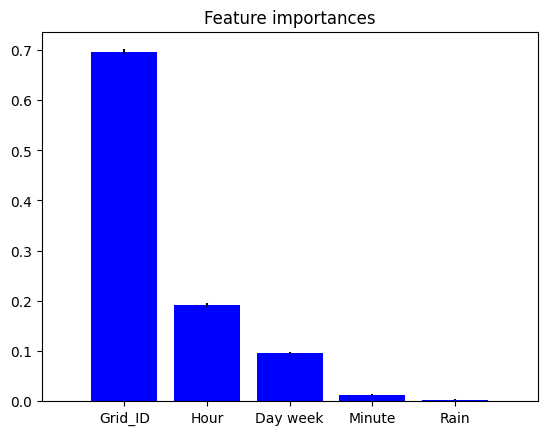

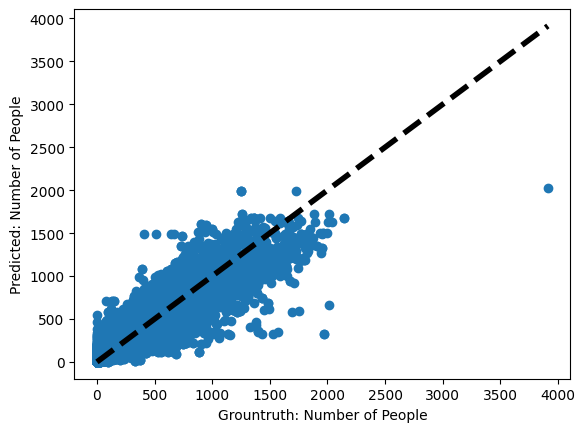

In [ ]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Print the R^2 score on the predictions
print("Test set prediction R^2 score:", r2_score(y_test, y_pred))

# Save the model to a file
joblib.dump(rf_model, 'rf_model.pkl')

# Generate feature importances plot
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), ['Grid_ID', 'Hour', 'Day week', 'Minute', 'Rain'])
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Plot predicted values against actual values for test set
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Grountruth: Number of People')
plt.ylabel('Predicted: Number of People')
plt.show()

## 🖼️ Visualisations


The animations that helped us visualize which grid ids were more movimented can be downloaded in this link: https://drive.google.com/drive/folders/1uxmWCOgZ7UlxxeeTbyw9KM3CF9aCLT2f?usp=share_link

## 👓 References

*   LisboaAberta ["Monitorization of Environmental Parameters in the city of Lisbon"](https://dados.cm-lisboa.pt/dataset/monitorizacao-de-parametros-ambientais-da-cidade-de-lisboa)



## ⏭️ Appendix


From the development / feature engineering section resulted a dataframe with information on which grid cells were affected by each conditioning, df_transitConditioning. The second step of adding conditioning impact for each row in the original table (df), if a conditioning was present for each datetime and grid id pair, is present below. This section was not performed until the end due to time constraincts.

In [ ]:
# Create conditioning level variable
conditioning_level = np.zeros((len(df.Grid_ID), 1), dtype=int)

df_transitConditioning['StartDatetime'] = pd.to_datetime(df_transitConditioning['StartDatetime'])
df_transitConditioning['EndDatetime'] = pd.to_datetime(df_transitConditioning['EndDatetime'])

# Loop through each conditioning
for k, conditioning in df_transitConditioning.iterrows():

  start_datetime = conditioning['StartDatetime']
  end_datetime = conditioning['EndDatetime']
  impact = conditioning["Impact"]

  # Get indexes of original dataframe which are affected for conditioning in terms of datetime
  indexes = df.index[(df['Datetime'] >= start_datetime) & (df['Datetime'] <= end_datetime)].tolist()

  for index in indexes:
    tmp_row = df.loc[[index]]
    tmp_grid_id = tmp_row['Grid_ID']

    # Check if the grid id is affected
    if conditioning[tmp_grid_id][0] == 1:

      # If so, add impact information
      if impact == 'Relevante':
        conditioning_level[index] += 2
      else:
        conditioning_level[index] += 1

Another information which would ideally be sent as features to the model would be Waze data. However, due to time constraincts this was not possible. Nevertheless, below follows a code that would be the starting point of this.

In [ ]:
# Load Waze data for the month of September

root_dir = '/content/drive/My Drive/WDL/1stPhase/DATA'
path_waze1 = os.path.join(root_dir,"Waze_QUEBRA_DE_SERIE/Set2022/CML_waze_jams_092022_1.csv") 
path_waze2 = os.path.join(root_dir,"Waze_QUEBRA_DE_SERIE/Set2022/CML_waze_jams_092022_2.csv")
path_waze3 = os.path.join(root_dir,"Waze_QUEBRA_DE_SERIE/Set2022/CML_waze_jams_092022_3.csv")
path_waze4 = os.path.join(root_dir,"Waze_QUEBRA_DE_SERIE/Set2022/CML_waze_jams_092022_4.csv")

df_waze_N1 = pd.read_csv(path_waze1, sep=',',  usecols=[ 'entity_ts', 'level', 'length', 'delay','speed'])
df_waze_N2 = pd.read_csv(path_waze2, sep=',', usecols=[ 'entity_ts', 'level', 'length', 'delay','speed'])
df_waze_N3 = pd.read_csv(path_waze3, sep=',', usecols=[ 'entity_ts', 'level', 'length', 'delay','speed'])
df_waze_N4 = pd.read_csv(path_waze4, sep=',', usecols=[ 'entity_ts', 'level', 'length', 'delay','speed'])

frames = [df_waze_N1, df_waze_N2, df_waze_N3, df_waze_N4]
tb_waze_N = pd.concat(frames, ignore_index=True)

In [ ]:
# Waze data sort by datetime
tb_waze_N = tb_waze_N.sort_values(by=['entity_ts'], ascending=True)

data = tb_waze_N['entity_ts']
tb_waze_N['Datetime']=pd.to_datetime(tb_waze_N['entity_ts'])

# Split day and time
data_list=list()
for ii in range(len(data.keys())):
  i=data.keys()[ii]
  data_list.append(data[i][:10]) # Day list

# Create column day, convert to datetime, and encoding day of week to int
tb_waze_N['day']=data_list 
data = pd.to_datetime(tb_waze_N['day'])
day_of_week = data.dt.weekday

# Adding new dataframe columns and dropping others
tb_waze_N['day_of_week'] = day_of_week
tb_waze_N['delay/length'] = tb_waze_N['delay']/tb_waze_N['length']
tb_waze_N=tb_waze_N.drop(columns=['delay', 'length','entity_ts', 'day'])

In [ ]:
# Replacing the exact datetime for the time slot of 15min that it belongs
dt_range = pd.date_range(start='2022-09-01 00:00:00+00:00', end='2022-10-01 00:00:00+00:00', freq='15min')

count=0
posit=0
while count<len(tb_waze_N['Datetime']):
  index=tb_waze_N['Datetime'].keys()[count]
  actual_time=tb_waze_N['Datetime'][index]
  for dt in range(posit, len(dt_range)-1):
    if (actual_time>=dt_range[dt] and actual_time<dt_range[dt+1]):

        tb_waze_N['Datetime'][count]=dt_range[dt]
        posit=dt
        count=count+1
        break

In [ ]:
aggregation = {
   'delay/length': ('max', lambda x: ((x > 0.9*x.max()) | (x < 0)).sum()),
    'level': (lambda x: sum(x > 4.5), 'count')
}

process_tbl=tb_waze_N.groupby(['Datetime']).agg(aggregation)
process_tbl['ratio_level']=process_tbl['level']['<lambda_0>']/process_tbl['level']['count']  ### Number of times in each the level as >4.5
process_tbl['n_waze_search']=process_tbl['level']['count']                                   ### Number of waze search for each 15min interval
process_tbl['delay/length>0.9']=process_tbl['delay/length']['<lambda_0>']                    ### The delay is proporcional to the length of the street, so we consider the ratio delay/length 
                                                                                             ### And count the number of times is higher that 0.9 max for that street or negative. This indicate the time intervals of higher traffic
process_tbl=process_tbl.drop(columns=['delay/length', 'level'])  

In [ ]:
display(process_tbl)